In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
# import celloracle as co

In [5]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
# adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'cell_type_2'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [6]:
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.rcParams['figure.dpi'] = 160
# sc.pl.embedding(adata, basis='spatial', 
#     color='cell_type', frameon=False, title='', 
#     legend_loc=None, size=60, add_outline=False, palette='tab20', 
#     outline_width=(0.2, 0.1), linewidth=0.2, edgecolor='black')

In [7]:
from spaceoracle.models.spatial_map import generate_grid_centers, distance
import numpy as np
from tqdm import tqdm
import random
from numba import jit

@jit(nopython=True)
def calculate_distances(random_point, centers, grid_size):
    dist_map = np.zeros((grid_size, grid_size))
    for i, center in enumerate(centers):
        u, v = divmod(i, grid_size)
        dist_map[u, v] = np.sqrt((random_point[0] - center[0])**2 + (random_point[1] - center[1])**2)
    return dist_map

@jit(nopython=True)
def normalize_maps(masked_distance_maps):
    n_cell_types, grid_size, _ = masked_distance_maps.shape
    normalized_maps = np.zeros_like(masked_distance_maps)
    
    for i in range(n_cell_types):
        min_val = np.inf
        max_val = -np.inf
        
        for u in range(grid_size):
            for v in range(grid_size):
                if masked_distance_maps[i, u, v] > 0:
                    min_val = min(min_val, masked_distance_maps[i, u, v])
                    max_val = max(max_val, masked_distance_maps[i, u, v])
        
        denominator = max(max_val - min_val, 1e-15)
        
        for u in range(grid_size):
            for v in range(grid_size):
                if masked_distance_maps[i, u, v] > 0:
                    normalized_maps[i, u, v] = (masked_distance_maps[i, u, v] - min_val) / denominator
    
    return normalized_maps

def generate_random_distance_map(coords_2d, cell_types, grid_size=64):
    """
    Generate a distance map from a random point with each channel masking a particular cell type.
    
    Args:
        coords_2d: 2D array of spatial coordinates (x, y)
        cell_types: Array of cell type labels corresponding to each coordinate
        grid_size: Size of the grid (default: 64x64)
    
    Returns:
        A distance map of shape (n_cell_types, grid_size, grid_size)
    """
    # Extract coordinates
    x, y = coords_2d[:, 0], coords_2d[:, 1]
    xmin, xmax, ymin, ymax = np.min(x), np.max(x), np.min(y), np.max(y)
    
    # Generate grid centers
    centers = generate_grid_centers(grid_size, grid_size, xmin, xmax, ymin, ymax)
    
    # Get unique cell types
    unique_cell_types = np.unique(cell_types)
    n_cell_types = len(unique_cell_types)
    
    # Choose a random point
    random_idx = random.randint(0, len(coords_2d) - 1)
    random_point = (coords_2d[random_idx, 0], coords_2d[random_idx, 1])
    
    # Create distance map using JIT-compiled function
    dist_map = calculate_distances(random_point, centers, grid_size)
    
    # Create masks for each cell type
    masks = np.zeros((n_cell_types, grid_size, grid_size))
    
    # Fill masks based on cell types
    for i, cell_type in enumerate(unique_cell_types):
        cell_indices = np.where(cell_types == cell_type)[0]
        for idx in cell_indices:
            x_coord, y_coord = coords_2d[idx]
            dist_to_centers = np.array([np.sqrt((x_coord - c[0])**2 + (y_coord - c[1])**2) for c in centers])
            nearest_center_idx = np.argmin(dist_to_centers)
            u, v = divmod(nearest_center_idx, grid_size)
            masks[i, u, v] = 1
    
    masked_distance_maps = np.zeros((n_cell_types, grid_size, grid_size))
    for i in range(n_cell_types):
        masked_distance_maps[i] = dist_map * masks[i]
    
    normalized_maps = normalize_maps(masked_distance_maps)
    
    return dist_map, normalized_maps


2025-07-09 17:04:38.856253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [8]:
# adata.obs = adata.obs.join(pd.read_csv('tonsil_cell_types.csv', index_col=0))
adata.obs['cell_type_major'] = adata.obs.cell_type_2.replace(
    {
        'GC Dark Zone': 'Germinal Center B cells', 
        'GC Light Zone': 'Germinal Center B cells', 
        'GC Intermediate Zone': 'Germinal Center B cells', 
        'plasma': 'Plasma cells', 
        'B_naive': 'B cells', 
        'B_memory': 'B cells', 
        'B_germinal_center': 'Germinal Center B cells', 
        'Naive CD4 T': 'T cells', 
        'Treg': 'T cells', 
        'T memory': 'T cells', 
        'Th1': 'T cells', 
        'Th2': 'T cells', 
        'T_CD8': 'T cells', 
        'T_follicular_helper': 'T cells', 
        'mDC': 'Dendritic cells', 
        'FDC': 'Dendritic cells', 
        'myeloid': 'Myeloid cells', 
        'NK': 'NK cells', 
        'pDC': 'Dendritic cells', 
        'T_double_neg': 'T cells'
    }
)

In [9]:
dist_map, normalized_maps = generate_random_distance_map(
    adata.obsm['spatial'], adata.obs.cell_type_major, grid_size=128)
dist_map.shape, normalized_maps.shape

((128, 128), (7, 128, 128))

In [10]:
import alphashape

ct_points_wt = {}
for ct in adata.obs['cell_type_major'].unique():
    points = np.asarray(
        adata[adata.obs['cell_type_major'] == ct].obsm['spatial'])
    delta = 30
    points = np.vstack(
        (points +[-delta,delta], points +[-delta,-delta], 
        points +[delta,delta], points +[delta,-delta]))
    ct_points_wt[ct] = points

alpha_shape = alphashape.alphashape(ct_points_wt['Germinal Center B cells'], alpha=0.035)

In [36]:
dist_map.shape

(128, 128)

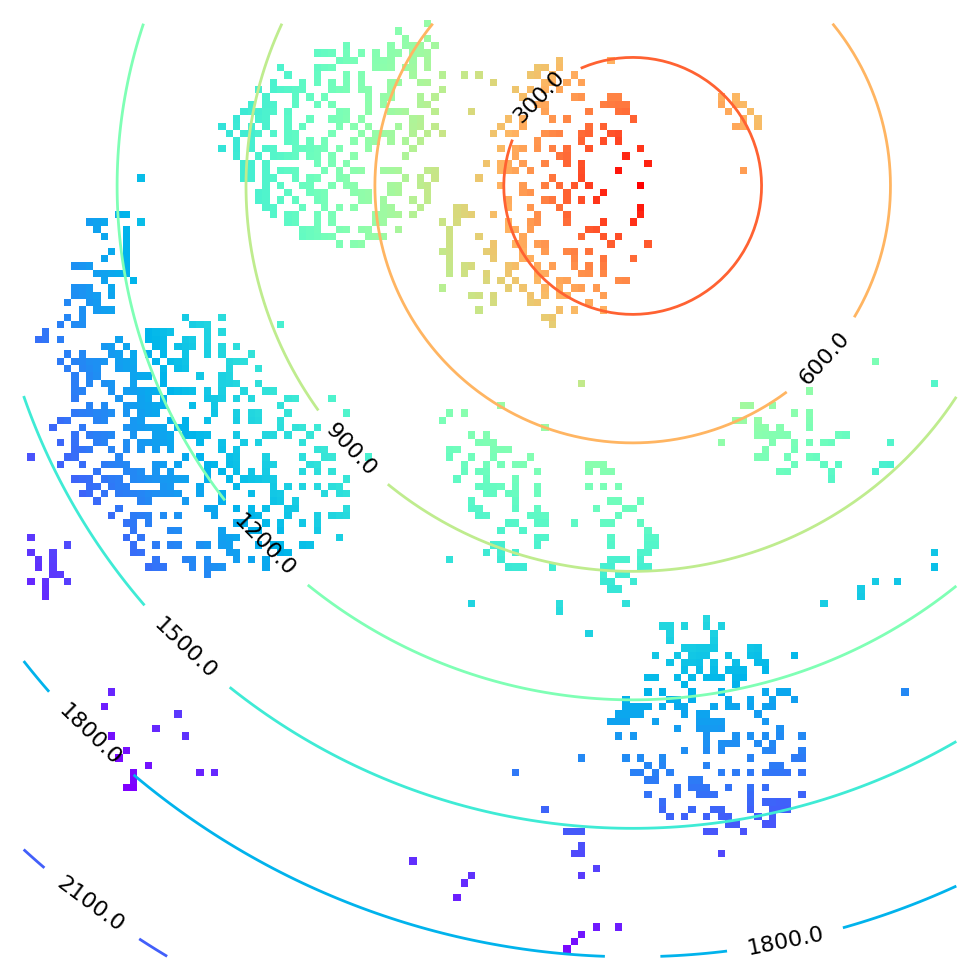

In [53]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100

from matplotlib.colors import LogNorm, CenteredNorm, PowerNorm

plt.imshow(np.where(normalized_maps[2] == 0, normalized_maps[2], normalized_maps[2] + 0.5), 
           cmap='rainbow_r', interpolation='none', 
           norm=LogNorm()
        )
contours = plt.contour(dist_map, levels=7, cmap='rainbow_r', linewidths=1)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.1f", colors='black')
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/demo_gaussligand.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [7]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil_colinks.pkl',
    # colinks_path='/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl',
    annot='cell_type_int'
)

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2025-07-07 21:44:31.289945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/li

In [25]:
co_grn.links['T_CD4'] =pd.concat([
    co_grn.links['T_CD4'], 
    pd.DataFrame(
        {
            'source': 'FOXO1',
            'target': 'CTLA4',
            'coef_mean': 1,
            'coef_abs': 1,
            'p': 0
        }, index=[0]
    )], axis=0)

co_grn.get_regulators(adata, 'CTLA4')

['EGR1',
 'FOXO1',
 'FOXS1',
 'GATA3',
 'MEIS1',
 'MEIS2',
 'PKNOX2',
 'SMAD3',
 'STAT3']

In [8]:
# links = pd.concat([
#         df for df in co_grn.links.values()], axis=0
#     ).sort_values('coef_abs', ascending=False).drop_duplicates(subset=['source', 'target'])
# links[(links['source'] == 'NFKB1') & (links['target'] == 'IRF4')]

In [26]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata, target_gene='CTLA4', cluster_annot='cell_type_int',
    radius=400, contact_distance=50, grn=co_grn)

In [27]:
estimator.fit(
    num_epochs=150, 
    threshold_lambda=1e-6, 
    learning_rate=5e-3,
    batch_size=512,
)

Fitting CTLA4 with 990 modulators
	9 Transcription Factors
	955 Ligand-Receptor Pairs
	26 TranscriptionFactor-Ligand Pairs
0: 0.9173 | 0.8105
1: 0.3474 | 0.3652
2: 0.4687 | 0.4846
3: 0.9057 | 0.8409
4: 0.6900 | 0.6213
5: 0.9156 | 0.8908
6: 0.4232 | 0.2893
7: 0.6900 | 0.6585
8: 0.7186 | 0.6946
9: 1.0000 | 1.0000
10: 0.9276 | 0.8854
11: 0.9960 | 0.9956
12: 0.9546 | 0.9596


In [31]:
betadata = estimator.betadata
betadata

,beta0,beta_EGR1,beta_FOXO1,beta_FOXS1,beta_GATA3,beta_MEIS1,beta_MEIS2,beta_PKNOX2,beta_SMAD3,beta_STAT3,...,beta_VEGFA#MEIS2,beta_BMP6#PKNOX2,beta_GDF11#PKNOX2,beta_PDGFD#PKNOX2,beta_TGFB1#PKNOX2,beta_TGFB2#SMAD3,beta_IFNG#SMAD3,beta_IL21#STAT3,beta_IL10#STAT3,beta_IL24#STAT3
NAME,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCTTG-1,-0.069462,-0.402391,-0.064526,4.454117e+00,-0.083400,-0.022259,1.446662,0.000000,0.190689,0.231765,...,0.000141,0.000000,0.000000,0.000000,0.000000,0.001797,0.002892,0.026498,0.002905,0.009806
AAACCCAAGTGGACGT-1,-0.014591,-0.062007,0.005856,0.000000e+00,0.049409,0.051031,0.019857,-0.003832,0.043230,0.005692,...,0.000000,0.000000,0.000000,0.000032,0.000000,-0.000000,-0.000000,0.000093,0.000000,-0.000011
AAACCCACAGAAGTGC-1,-0.003227,-0.004127,0.000418,1.241768e-07,0.285785,0.002331,0.018807,0.000245,0.001553,-0.000115,...,0.000181,-0.000586,0.000143,-0.039726,0.002096,-0.000677,0.004717,0.011044,0.001615,0.018603
AAACCCAGTCATTGCA-1,-0.001917,0.082973,-0.001668,0.000000e+00,0.009262,0.032280,0.001845,0.000000,0.000211,0.005825,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000002,-0.000002,-0.000014,-0.000000,-0.000008
AAACCCATCATCGCAA-1,-0.000097,0.344039,-0.004999,0.000000e+00,0.138983,-0.004551,-0.051616,0.000000,-0.003418,0.015125,...,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.001205,0.000775,0.001412,0.000368,-0.000229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGGGACTA-1,-0.025945,-0.004350,0.002314,9.864028e-01,0.275498,0.359969,0.101835,0.792915,0.033287,-0.000123,...,0.000103,-0.000570,0.000410,-0.006798,0.003338,-0.000501,0.004469,0.057401,0.001084,0.006686
TTTGTTGCATTGTAGC-1,-0.014530,-0.061801,0.005841,0.000000e+00,0.049039,0.050676,0.019787,-0.003839,0.043257,0.005699,...,0.000000,0.000000,0.000000,0.000032,0.000000,-0.000000,-0.000000,0.000093,0.000000,-0.000011
TTTGTTGGTACCACGC-1,-0.005724,-0.029217,0.000415,3.392429e-05,0.502999,0.007053,0.036355,0.006849,0.007161,-0.000322,...,0.000170,-0.000551,0.000264,-0.039147,0.002225,-0.000653,0.004370,0.019801,0.001637,0.016468


In [37]:
[x for x in betadata.columns if 'FOXO1' in x]

['beta_FOXO1', 'beta_TGFB3#FOXO1', 'beta_BMP2#FOXO1', 'beta_PDGFD#FOXO1']

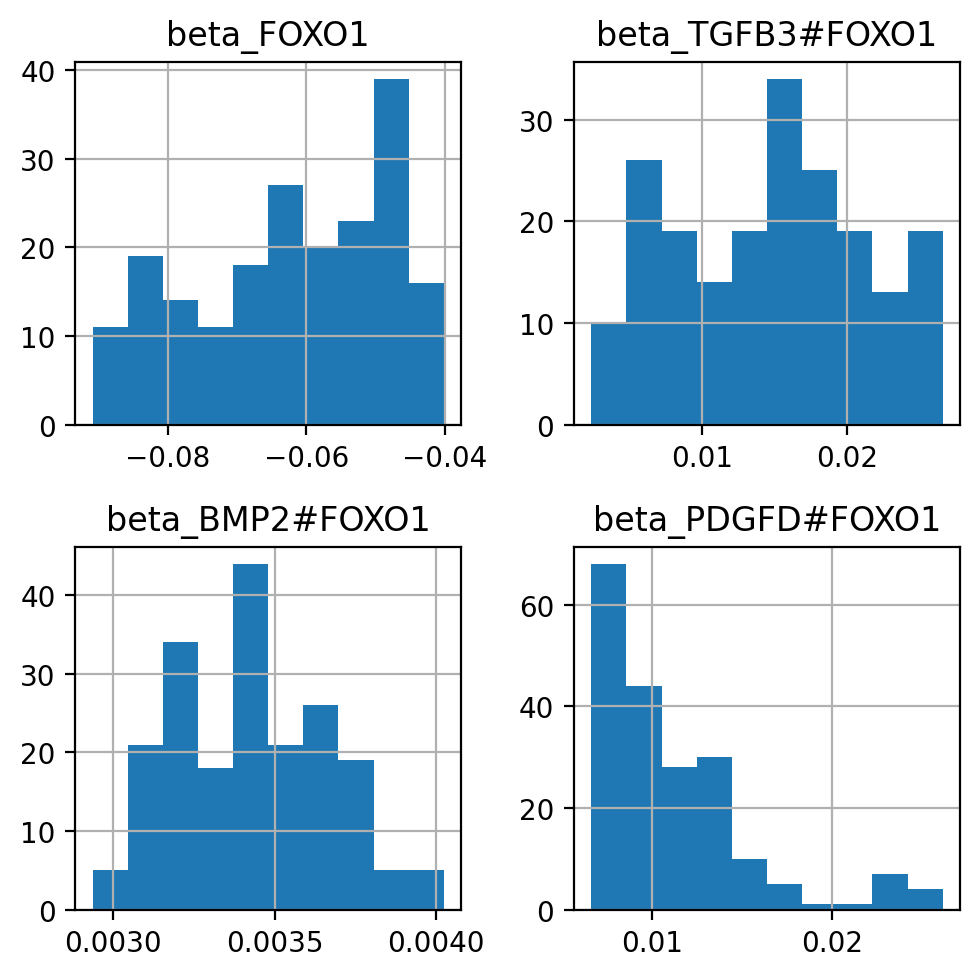

array([[<Axes: title={'center': 'beta_FOXO1'}>]], dtype=object)

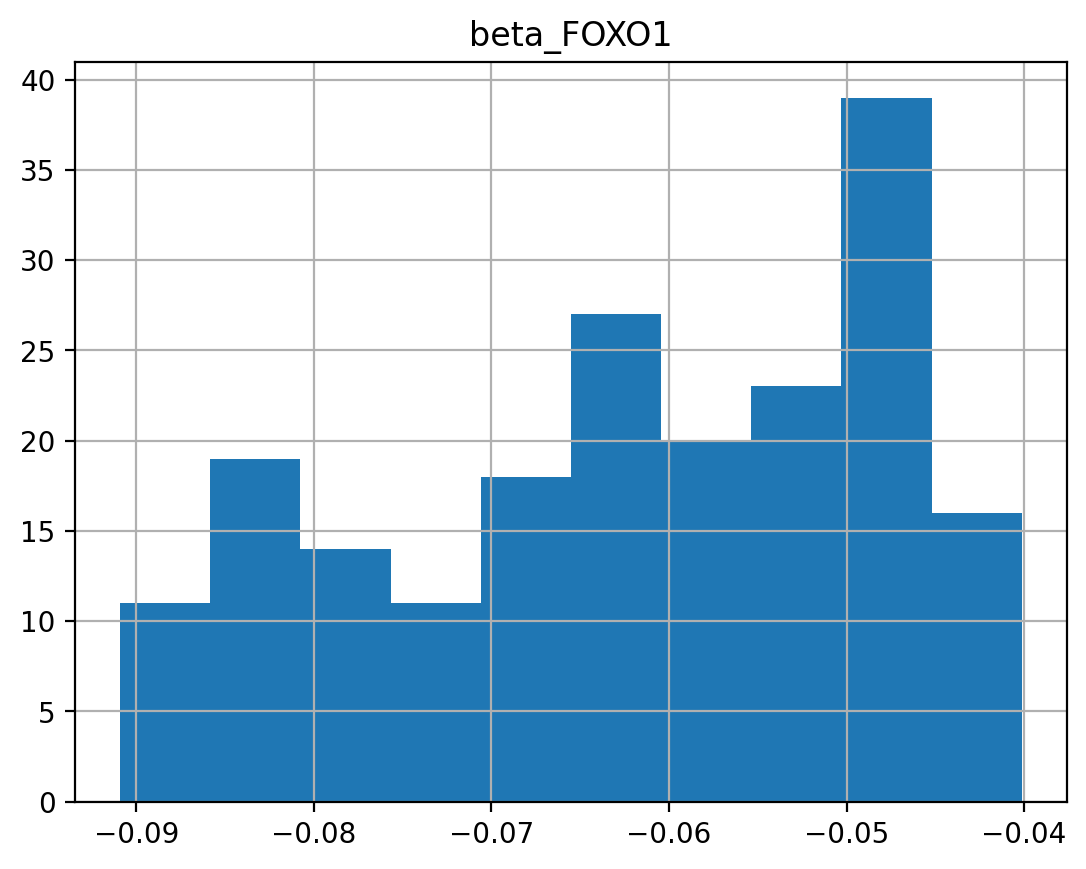

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.flatten()
for i, mod in enumerate([x for x in betadata.columns if 'FOXO1' in x]):
    betadata.loc[adata[adata.obs.cell_type_2 == 'Treg'].obs.index, [mod]].hist(ax=axs[i])
    axs[i].set_title(mod)
plt.tight_layout()
plt.show()
betadata.loc[adata[adata.obs.cell_type_2 == 'Treg'].obs.index, ['beta_FOXO1']].hist()

In [35]:
betadata.to_parquet(f'/ix/djishnu/shared/djishnu_kor11/lasso_runs/human_tonsil/{estimator.target_gene}_betadata.parquet')

,SMAD1,SOX9
NAME,,
AAACCCAAGCGCCTTG-1,0.029213,0.000000
AAACCCAAGTGGACGT-1,0.101690,0.004319
AAACCCACAGAAGTGC-1,0.023756,0.016586
AAACCCAGTCATTGCA-1,0.021847,0.000646
AAACCCATCATCGCAA-1,0.007771,0.000369
...,...,...
TTTGTTGCAGGGACTA-1,0.044012,0.003452
TTTGTTGCATTGTAGC-1,0.140092,0.000534
TTTGTTGGTACCACGC-1,0.069569,0.001041


['beta_IL4$IL4R',
 'beta_IL4$IL13RA1',
 'beta_IL4#EGR2',
 'beta_IL4#ERG',
 'beta_IL4#GLIS3',
 'beta_IL4#NR4A3',
 'beta_IL4#TCF7L2']

In [48]:
betadata[[i for i in betadata.columns if 'IL' in i and '$' in i]].join(estimator.adata.obs.cell_type).groupby(
    'cell_type').mean()

,beta_IL4$IL4R,beta_IL7$IL7R,beta_IL15$IL2RB,beta_IL4$IL13RA1,beta_IL6$IL6R,beta_IL6$IL6ST,beta_EBI3$IL27RA,beta_EBI3$IL6ST,beta_IL18$IL18R1,beta_IL18$IL18RAP,beta_IL33$IL1RAP,beta_IL34$CSF1R,beta_HLA-G$LILRB2
cell_type,,,,,,,,,,,,,
B memory,0.000000,0.000000,-0.044792,-0.000037,-0.001142,0.005375,0.011358,0.005166,-0.012901,-0.002193,0.001491,0.000000,0.0
B naive,0.008740,0.000000,0.000000,-0.000466,0.000000,0.001760,0.008953,-0.001294,-0.004691,0.000218,0.003283,-0.000358,0.0
CD4+ T,0.001843,-0.519587,-0.044622,0.000000,-0.000759,0.000393,-0.002803,-0.026032,-0.031784,-0.011276,-0.001473,0.000000,0.0
DC,0.010088,-0.304780,0.017162,0.000751,-0.016225,-0.027998,-0.031694,-0.147217,-0.334772,-0.007393,-0.004979,-0.009612,0.0
GC B,0.009088,0.000000,-0.002606,-0.000522,0.000000,0.000000,0.054314,0.000000,-0.000729,-0.000280,0.000000,0.000000,0.0
Macrophages,0.000682,0.020048,0.000008,0.000810,-0.001192,-0.001131,0.000000,0.009346,0.000008,0.000000,-0.001422,-0.002741,0.0
Plasma,0.009566,0.000000,0.016529,-0.000087,-0.006139,-0.006866,0.005738,-0.147408,-0.005666,-0.007990,0.000317,-0.000003,0.0
T cells,0.002333,-1.432863,-0.065362,0.001244,-0.005073,-0.003925,-0.020328,-0.019495,-0.064137,-0.044997,-0.001654,0.000000,0.0
Tfh,0.000000,-0.259885,0.006133,0.000163,-0.006090,-0.010608,-0.035781,-0.193373,0.024539,0.000000,0.002285,0.000000,0.0


In [10]:
# df = received_ligands(
#     adata.obsm['spatial'], 
#     get_ligands_df(adata.to_df(layer='imputed_count'), adata.obs['cell_thresholds'], estimator.ligands),
#     lr_info=estimator.lr 
# )

# df_nofilt = received_ligands(
#     adata.obsm['spatial'], 
#     get_ligands_df(adata.to_df(layer='imputed_count'), np.zeros(adata.n_obs), estimator.ligands),
#     lr_info=estimator.lr 
# )

# (df - df_nofilt).sum(axis=0)

In [16]:
from spaceoracle.prophets import Prophet
import anndata as ad
import pandas as pd
import matplotlib

In [18]:
betadata.to_parquet(f'/tmp/{estimator.target_gene}_betadata.parquet')

In [20]:
pythia = Prophet(
    adata=estimator.adata,
    models_dir='/tmp/',
    annot='cell_type_int',
)

Fitting ANKFN1 with 359 modulators
	31 Transcription Factors
	244 Ligand-Receptor Pairs
	84 TranscriptionFactor-Ligand Pairs
0: x.xxxx | 0.5970
1: x.xxxx | 0.5585
2: x.xxxx | 0.5236
3: 0.8538 | 0.8936
4: 0.4016 | 0.4938
5: x.xxxx | 0.8746
6: 0.3441 | 0.7796
7: 0.6364 | 0.9114
8: x.xxxx | 0.5877


In [ ]:
gex_df = estimator.adata.to_df(layer=estimator.layer)
pythia.compute_betas()
gene_mtx = pythia.adata.layers['imputed_count']
weighted_ligands = pythia._compute_weighted_ligands(gene_mtx)
beta_dict = pythia._get_wbetas_dict(
    pythia.beta_dict, weighted_ligands, gene_mtx)
wbetas = beta_dict.data[estimator.target_gene].wbetas
xy = beta_dict.xydf.copy()
xy.columns = ['x', 'y']
df = wbetas \
        .join(estimator.adata.obs) \
        .join(xy) \
        .join(gex_df)

In [ ]:
beta_cols_df = [i for i in df.columns if 'beta_' in i and i.replace('beta_', '') in np.unique(estimator.ligands)]

In [ ]:
beta_cols = [i for i in betadata.columns if 'beta_' in i and '$' in i]

In [ ]:
betadata[beta_cols].mean().sort_values(ascending=False)

In [ ]:
df[['beta_GAS6', 'beta_NPPC']].mean()

In [ ]:
# Create figure with 4 subplots in 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=200)
axes = axes.flatten()

modulator = 'CCL21'

# Join data once for efficiency
plot_data = df[[f'beta_{modulator}', 'x', 'y', 'cell_type']].join(adata.to_df(layer='imputed_count'))

# Common plot settings
plot_settings = {
    'linewidth': 0.2,
    'edgecolor': 'black',
    's': 30
}

# Plot for cell_type
sns.scatterplot(
    data=plot_data,
    x='x',
    y='y', 
    hue='cell_type',
    palette='tab20',
    legend='brief',
    ax=axes[0],
    **plot_settings
)
axes[0].set_title('Cell Type', fontsize=14)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for modulator gene with colorbar
scatter1 = axes[1].scatter(
    plot_data['x'],
    plot_data['y'],
    c=plot_data[modulator],
    cmap='viridis',
    **plot_settings
)
axes[1].set_title(modulator, fontsize=14)
plt.colorbar(scatter1, ax=axes[1], shrink=0.5)

# Plot for target gene with colorbar  
scatter2 = axes[2].scatter(
    plot_data['x'],
    plot_data['y'],
    c=plot_data[estimator.target_gene], 
    cmap='magma',
    **plot_settings
)
axes[2].set_title(estimator.target_gene, fontsize=14)
plt.colorbar(scatter2, ax=axes[2], shrink=0.5)

# Plot for beta_modulator with colorbar
scatter3 = axes[3].scatter(
    plot_data['x'],
    plot_data['y'],
    c=plot_data[f'beta_{modulator}'],
    cmap='rainbow', 
    **plot_settings
)
axes[3].set_title(f'Beta {modulator}', fontsize=14)
plt.colorbar(scatter3, ax=axes[3], shrink=0.5)

# Remove ticks and set equal aspect for all axes
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_frame_on(False)

# Remove borders from legends
for ax in axes:
    legend = ax.get_legend()
    if legend is not None:
        legend.set_frame_on(False)

plt.tight_layout()
plt.show()

In [ ]:
import commot as ct

In [ ]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type="Secreted Signaling"
    )
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
          

In [ ]:
df_ligrec.query('ligand == "CCL21"')